## Тестирование нового шрифта.
В проекте будет исследоваться воронка событий и результаты А/А/В-эксперимента. Группы 246 и 247 - контрольные, 248 - тестовая. Есть 5 видов событий, для каждого имеется номер устройства, время события и группа.

А/А/В-тест должен будет подтвердить или опровергнуть различие в отношениях количества пользователей, совершивших событие, к общему количеству пользователей. Для этого будет использоваться Z-критерий.

В ходе исследования будут проведены подготовка и изучение данных, будет проверена корректность работы механизмов и  проведен А/А-тест, и после его успешного завершения будет произведен А/В-тест.

## План работы.

1. [Открытие файлов](#download)
2. [Предобработка данных](#preprocessing)
3. [Анализ данных](#analysis)
4. [Изучение воронки событий](#funnel-analysis)
5. [Проведение А/В-теста](#ab-test)
6. [Результаты исследования и рекомендации](#ending)

In [73]:
import numpy as np
import pandas as pd
import scipy.stats as st
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

plt.style.use('seaborn')

In [37]:
params = {'axes.titlesize': 15,
          'axes.labelsize': 13
         }

plt.rcParams.update(params)

Для работы нам понадобятся следующие функции.

In [59]:
def get_grouped_data(data, group_column, value_column, rename_column='amount', aggfunc='count'):
    ''' Возвращает сгруппированные данные'''
    return (data.groupby(group_column, as_index=False) # группировка
            .agg({value_column: aggfunc}) # применение фукнции к столбцу
            .sort_values(by=value_column, ascending=False)
            .rename(columns={value_column: rename_column})
           )

def plot_bar(data, x, y, xticks_rotation=0, ax=None):
    '''Возвращает столбчатую диаграмму по данным data,
       где x и y - столбцы, по которым строится диаграмма,
       '''

    ax = sns.barplot(data=data, x=x, y=y, ax=ax)
    
    for tick in ax.get_xticklabels(): # поварачиваем метки оси абсцисс на графике
        tick.set(rotation=xticks_rotation, ha='left') 
    return ax

#### Шаг 1. Открытие файла и общая информация. <a class='anchor' id='download'></a>

In [5]:
path = ''
logs = pd.read_csv(path + 'logs_exp.csv', delimiter='\t') # считываем данные, разделитель - символ табуляции
logs.sample(3) # 5 случайных событий

,EventName,DeviceIDHash,EventTimestamp,ExpId
170274,MainScreenAppear,6754200723710620075,1565025985,246
71424,MainScreenAppear,6332565246182501322,1564774405,248
138612,CartScreenAppear,6234930871538147758,1564947901,247


In [6]:
logs.info() # выводим информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Мы располагаем данными о 244 тысячах событий, для каждого события в таблице есть название, хеш устройства, дата и группа. Дата представлена в виде количества секунд.

#### Шаг 2. Предобработка данных. <a class='anchor' id='preprocessing'></a>

Подготовим данные для анализа. Для этого переименуем столбцы, удалим пропуски, переведем время в читаемый тип, а также добавим столбец с датой события.

In [8]:
logs = logs.rename(columns={'EventName': 'event_name',
                            'DeviceIDHash': 'device_id',
                            'EventTimestamp': 'event_timestamp',
                            'ExpId': 'exp_id'
                           }
                  )

In [7]:
logs.isna().sum() # количество пропусков

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

Пропусков в данных нет.

In [9]:
logs.duplicated().sum() # количество дубликатов

413

В данных более 400 дубликатов. Это несколько одинаковых событий с одного устройства, произошедшие в одно время в точности до секунды. Посмотрим, что это за события.

In [10]:
logs[logs.duplicated()]['event_name'].unique()

array(['MainScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

В каждом событии есть дубликаты. Наврятли они являются чем-то иным, кроме технической ошибки, значит от дубликатов можно избавиться.

In [12]:
logs = logs.drop_duplicates(ignore_index=True) # удаляем дубликаты

Изменим типы данных, где необходимо.

In [13]:
logs.dtypes # типы данных

event_name         object
device_id           int64
event_timestamp     int64
exp_id              int64
dtype: object

Столбец с временем содержит количество секунд. Следует перевести их в дату и время. Для остальных столбцов никаких преобразований не требуется.

In [15]:
logs['event_timestamp'] = pd.to_datetime(logs['event_timestamp'],
                                         origin='unix', unit='s'
                                        ) # переводим секунды в дату и время
logs['event_timestamp'].sample(5)

144724   2019-08-05 06:24:06
158581   2019-08-05 13:16:50
163624   2019-08-05 15:09:04
58749    2019-08-02 13:39:31
81110    2019-08-03 08:20:53
Name: event_timestamp, dtype: datetime64[ns]

Также нам будут необходимы даты событий.

In [16]:
logs['event_date'] = logs['event_timestamp'].dt.date # извлекаем дату
logs.sample(5)

,event_name,device_id,event_timestamp,exp_id,event_date
86428,PaymentScreenSuccessful,377428696293052237,2019-08-03 10:51:19,248,2019-08-03
181460,OffersScreenAppear,184986614767762738,2019-08-06 06:04:47,248,2019-08-06
62074,MainScreenAppear,299409047914517767,2019-08-02 15:04:20,248,2019-08-02
94553,PaymentScreenSuccessful,4276715305122105458,2019-08-03 14:14:55,246,2019-08-03
108017,MainScreenAppear,2415188714574108464,2019-08-04 01:26:02,247,2019-08-04


##### Промежуточный вывод: 

В данных нет пропущенных значений, но есть дубликаты. Также было необходимо изменить тип данных для времени события и извлечь дату события.

#### Шаг 3. Анализ данных. <a class='anchor' id='analysis'></a>

Посмотрим на временной промежуток теста, количество пользователей и событий. У нас имеется информация о следующих событиях:

In [17]:
logs['event_name'].unique() # уникальные названия событий

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Событиями являются просмотр главной страницы, успешная оплата, просмотр страницы карзины, страницы предложения и страницы обучения. Теперь посмотрим на группы, учавствовавшие в тесте. 

In [13]:
logs['exp_id'].unique() # группы

array([246, 248, 247], dtype=int64)

У нас 3 группы, 2 контрольные - 246 и 247, и одна тестовая - 248.

In [20]:
print(f'Всего событий в логе - {logs["event_name"].count()}.')
print(f'Всего пользователей в логе - {logs["device_id"].nunique()}.')

mean_events_by_user = logs['event_name'].count() / logs['device_id'].nunique()
print(f'В среднем пользователь совершает {mean_events_by_user:.2f} событий.')

print(f'В данных данные о событиях с {logs["event_date"].min()} по {logs["event_date"].max()}.')

test_duration = (logs['event_date'].max() - logs['event_date'].min()).days # длительность теста в днях
print(f'Тест продолжался {test_duration} дней.')

Всего событий в логе - 243713.
Всего пользователей в логе - 7551.
В среднем пользователь совершает 32.28 событий.
В данных данные о событиях с 2019-07-25 по 2019-08-07.
Тест продолжался 13 дней.


Посмотрим на распределение количество событий по пользователям.

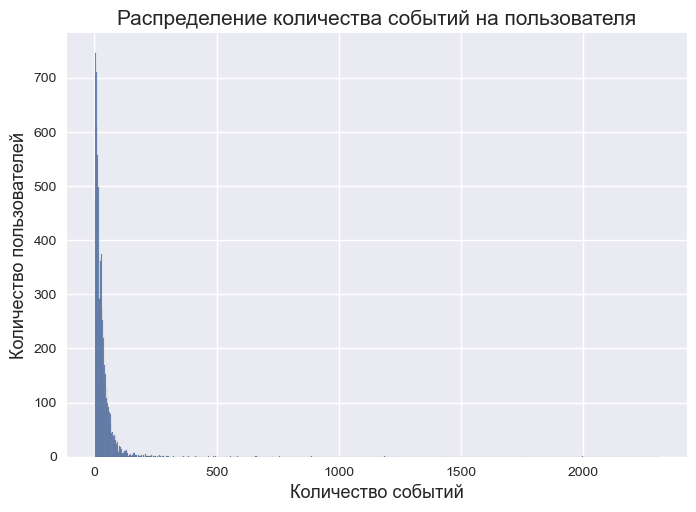

In [38]:
events_by_user = get_grouped_data(logs, group_column='device_id', value_column='event_name')

ax = sns.histplot(events_by_user['amount'])

ax.set(title='Распределение количества событий на пользователя',
       xlabel='Количество событий', ylabel='Количество пользователей'
      )
plt.show()

Пользователи с более 2 тысячами событий смещают график влево. Исключим их и посмотрим на оставшихся.

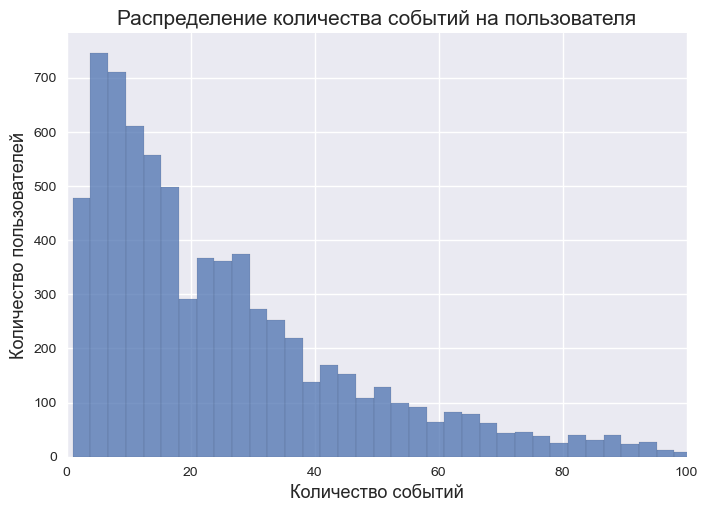

In [45]:
ax = sns.histplot(events_by_user['amount'])

ax.set(title='Распределение количества событий на пользователя',
       xlabel='Количество событий', ylabel='Количество пользователей'
      )

plt.xlim(0, 100)
plt.show()

Построим гистограмму по дате и времени. Количество столбцов поставим 312, по 24 на каждый день.

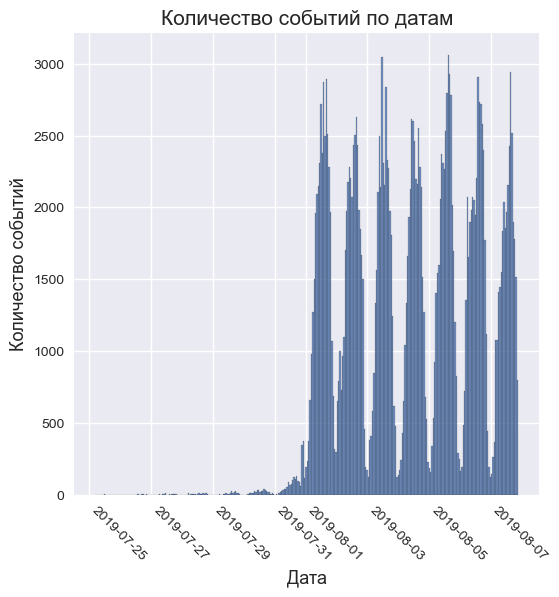

In [46]:
plt.figure(figsize=(6, 6))
ax = sns.histplot(logs.event_timestamp, bins=312) 

ax.set(title='Количество событий по датам',
       xlabel='Дата', ylabel='Количество событий'
      )

plt.xticks(rotation=-45, ha='left') # поворот дат для удобочитаемости
plt.show()

На графике видно, что событий в июле почти нет, а с августа их количество поднимается до 20 тысяч, поэтому актуальным периодом можно обозначить с 1 по 7 августа 2019 года, более ранние даты можно отбросить.

In [49]:
logs = logs.query('event_date >= datetime.date(2019, 8, 1)') # все даты равные или позднее 1-го августа 2019 года.

In [50]:
print(f'Событий в логе после удаления старых данных - {logs["event_name"].count()}.')

print(f'Это {logs["event_name"].count() / 243713:.2%} от всех событий.')

print(f'\nВсего пользователей в логе после удаления старых данных - {logs["device_id"].nunique()}.')

print(f'Это {logs["device_id"].nunique() / 7551:.2%} от всех пользователей.')

Событий в логе после удаления старых данных - 240887.
Это 98.84% от всех событий.

Всего пользователей в логе после удаления старых данных - 7534.
Это 99.77% от всех пользователей.


Мы избавились всего от менее 1.2% событий и от менее 0.3% пользователей. Теперь проверим экспериментальные группы.

In [51]:
logs.groupby('exp_id')['device_id'].nunique() # количество пользователей в группе

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

Имеется по 2.5 тысячи пользователей с каждой группы. Проверим, есть ли те, кого определили в несколько групп.

In [53]:
(logs[['device_id', 'exp_id']].drop_duplicates() # оставляем только уникальные пары устройство - группа
 .groupby('device_id') # группируем по устройству
 ['device_id']
 .count() # для каждого устройства считаем количество групп, в которые он входит
 .max()) # выводим максимальное количество 

1

Каждому устройству соответствует только одно экспериментальная группа.

##### Промежуточный вывод: 
Пользователи могут совершить 5 событий, просмотреть главную страницу, страницу обучения, страницу предложения, страницу карзины и покупку. 

Всего около 244 тысяч событий и 7,5 тысяч пользователей за промежуток с 25 июля по 7 августа 2019 года, но предпочтительнее будет выбрать период теста с 1 по 7 августа, так как именно в этот период пользователи совершили более 98% событий.

Экспериментальные группы разделены примерно поровну, по 2,5 тысяч пользователей, и среди них нет тех, кого отнесли к разным группам.

#### Шаг 4. Изучение воронки событий. <a class='anchor' id='funnel-analysis'></a>

##### Частота событий.

In [36]:
logs.event_name.unique() # все события

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

Пользователи совершают просмотр главной страницы, страницы предложения, страницы карзины, покупку и обучение.

In [54]:
events_number = get_grouped_data(logs, group_column='event_name', value_column='device_id')

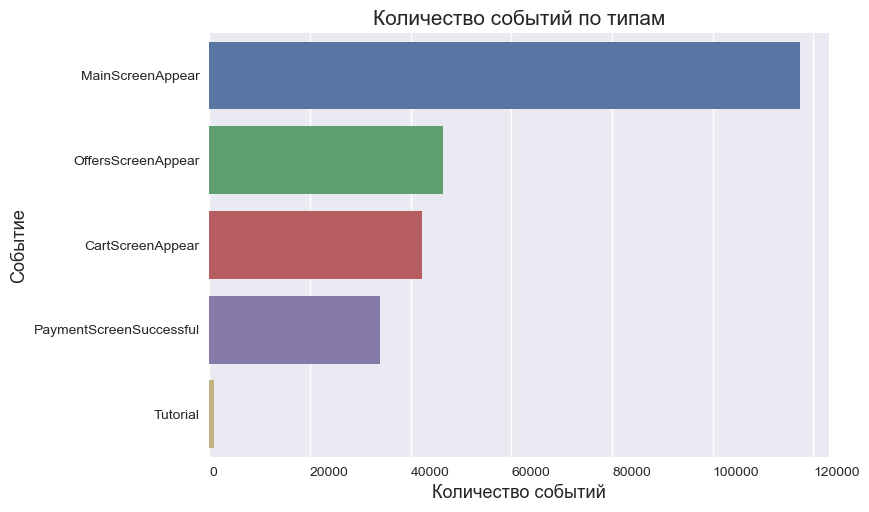

In [64]:
ax = plot_bar(events_number,
              x='amount', y='event_name'
             )

ax.set(title='Количество событий по типам',
       xlabel='Количество событий', ylabel='Событие'
      )

plt.show()

Наиболее часто пользователи просматривают главную страница, меньше всего - проходят обучение.

##### Сколько пользователей совершали события.

In [79]:
n_users = logs['device_id'].nunique() # общее количество пользователей

users = get_grouped_data(logs, group_column='event_name',
                         value_column='device_id', aggfunc='nunique',
                         rename_column='number_of_users'
                        )

fig = go.Figure(data=[go.Funnel(x=users['number_of_users'], y=users['event_name'],
                                textinfo='value+percent initial'
                               )
                     ]
               )

fig.show()

Некоторые пользователи пропускают просмотр главной страницы и сразу переходят к предложению или корзине, почти половина пользователей совершают покупку, а 11% - проходят обучение.

##### Воронка событий.

Скорее всего воронка выглядит так: главная страница -> страница предложения -> страница корзины -> покупка. Судя по количеству пользователей, обучение не является требованием для какого-либо события и не открывается после выполнения другого события, поэтому оно не входит в воронку.

In [81]:
logs = logs.query('event_name != "Tutorial"')

In [84]:
users

,event_name,number_of_users
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [85]:
users['funnel'] = users['number_of_users'] / (users['number_of_users']
                                              .shift()
                                              .fillna(users['number_of_users'].max()))

In [87]:
users[['event_name', 'number_of_users', 'funnel']].rename(columns={'event_name': 'Событие', 
                                                                   'number_of_users': 'Количество пользователей',
                                                                   'funnel': 'Доля с предыдущего шага'
                                                                  }
                                                         )

,Событие,Количество пользователей,Доля с предыдущего шага
1,MainScreenAppear,7419,1.000000
2,OffersScreenAppear,4593,0.619086
0,CartScreenAppear,3734,0.812976
3,PaymentScreenSuccessful,3539,0.947777
4,Tutorial,840,0.237355


Только 62% пользователей с главной страницы переходят на страницу с предложением. Но 81% из них переходят в карзину, и почти все успешно завершают покупку. То есть больше всего пользователей теряется на переходе на страницу с предложением. Долю пользователей, прошедших с первый по последний шаги, можно посмотреть в предыдущей таблице, или посчитать, перемножив все доли. Около 47% пользователей доходят до покупки.

##### Промежуточный вывод:

Наиболее частым событием является просмотр главной страницы, наимение - прохождение обучения. Их совершают 117 тысяч и 1 тысячу соответственно, совершивших их пользователей - 7,4 тысячи и 840 соответсвтенно. Воронкой является последовательность событий главная страница -> страница предложения -> страница корзины -> покупка, обучение в воронку не входит. Около 47% пользователей полностью проходят воронку. Большая часть пользователей отпадает перед переходом на страницу с предложением, вероятно следует улучшить то, как пользователей завлекают на эту страницу.

#### Шаг 5. Изучение результатов эксперимента. <a class='anchor' id='ab-test'></a>

In [80]:
n_users_in_exp = logs.groupby('exp_id')['device_id'].nunique()
n_users_in_exp # сохраним в переменную, чтобы обращатся к ней в дальнейшем

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

Количество пользователей в каждой экспериментальной группе примерно одинаково и равно 2500.

##### А/А-тест.

Для проверки корректности А/B-теста нужно убедится, что никакой разницы в двух контрольных группах нет. Для этого сравним доли пользователей, которые прошли определенные шаги воронки. Для проверки статистической значимости посчитаем Z-критерий.

In [88]:
# Также избавимся от событий обучения
logs_246 = logs.query('exp_id == 246') 
logs_247 = logs.query('exp_id == 247')
logs_248 = logs.query('exp_id == 248')

Для начала сравним сами доли, не прибегая к статистике.

In [91]:
for funnel_step in logs['event_name'].unique():
    print(f'Шаг воронки - {funnel_step}.')
    
    prop_246 = logs_246.query('event_name == @funnel_step')['device_id'].nunique() / n_users_in_exp[246]
    prop_247 = logs_247.query('event_name == @funnel_step')['device_id'].nunique() / n_users_in_exp[247]
    
    print(f'Доля группы 246 - {prop_246:.3f}, доля группы 247 - {prop_247:.3f}.')
    print(f'Отношение доли группы 246 к 247 - {abs(prop_246 / prop_247 - 1):.4f}.\n')

Шаг воронки - MainScreenAppear.
Доля группы 246 - 0.986, доля группы 247 - 0.985.
Отношение доли группы 246 к 247 - 0.0011.

Шаг воронки - OffersScreenAppear.
Доля группы 246 - 0.621, доля группы 247 - 0.605.
Отношение доли группы 246 к 247 - 0.0263.

Шаг воронки - CartScreenAppear.
Доля группы 246 - 0.510, доля группы 247 - 0.493.
Отношение доли группы 246 к 247 - 0.0346.

Шаг воронки - PaymentScreenSuccessful.
Доля группы 246 - 0.483, доля группы 247 - 0.461.
Отношение доли группы 246 к 247 - 0.0484.



Доли отличаются менее чем на 5%. Это небольшое различие, поэтому проверим, является ли оно статистически значимым. 

Применим Z-тест. Z-критерий равен: 

$$
 z = \frac{P_1 - P_2}{\sqrt{P(1 - P)(\frac{1}{n_1} + \frac{1}{n_2})}}
\\ где \ P_1, \ P_2 \ - \ доли \ в \ выборках, \ n_1, \ n_2 \ - \ размер \ выборок, \ P \ - \ объединенная \ доля. 
$$

После вычисления Z-критерия, необходимо сравнить его с критическим значением стандартного нормального распределения.

Нулевой гипотезой будет отсутствие различия в доле пользователей совершивших определенное действие к общему количеству пользователей,

альтернативной - присутствие статистически значимого различия в этих долях.

Уровень значимости возьмем 5%. Однако, так как мы сравниваем сразу 8 гипотез попарно, необходимо ввести поправку, поэтому разделим уровень значимости на 4.

In [94]:
def z_test(group_log_A, group_log_B, alpha): # производит Z-тест над 2 выборками
    for funnel_step in logs['event_name'].unique():
        print(f'\nШаг воронки {funnel_step}.')
         
        # количество пользователей в группе
        n_1 = group_log_A['device_id'].nunique()
        n_2 = group_log_B['device_id'].nunique()
    
        # частота некоторого события в группе
        p_1 = group_log_A.query('event_name == @funnel_step')['device_id'].nunique() / n_1
        p_2 = group_log_B.query('event_name == @funnel_step')['device_id'].nunique() / n_2
    
        # общая частота
        p = (p_1 * n_1 + p_2 * n_2) / (n_1 + n_2)
    
        # z-критерий
        z = (p_1 - p_2) / np.sqrt(p * (1 - p) * (1 / n_1 + 1 / n_2))
    
        p_value = (1 - st.norm().cdf(abs(z))) * 2
        
        print(f'P-значение равно {p_value:.3f}.')
        
        if p_value < alpha:
            print(f'Отвергаем нулевую гипотезу и принимаем альтернативную. {p_value:.3f} < {alpha:.3f}.')
        else:
            print(f'Не получилось отвергнуть нулевую гипотезу. {p_value:.3f} >= {alpha:.3f}.')

In [97]:
alpha = .05 / 4

z_test(logs.query('exp_id == 246'), logs.query('exp_id == 247'), alpha)


Шаг воронки MainScreenAppear.
P-значение равно 0.753.
Не получилось отвергнуть нулевую гипотезу. 0.753 >= 0.013.

Шаг воронки OffersScreenAppear.
P-значение равно 0.248.
Не получилось отвергнуть нулевую гипотезу. 0.248 >= 0.013.

Шаг воронки CartScreenAppear.
P-значение равно 0.229.
Не получилось отвергнуть нулевую гипотезу. 0.229 >= 0.013.

Шаг воронки PaymentScreenSuccessful.
P-значение равно 0.114.
Не получилось отвергнуть нулевую гипотезу. 0.114 >= 0.013.


Статистический также не подтвердил различие в долях. Значит контрольные группы 246 и 247 действительно равны, все механизмы и расчеты работают корректно, и мы можем приступить к A/B-тесту. Сначала произведем тест на 246 и тестовой 248 группах.

Нулевыми гипотезами будут гипотезы об отутствии различия в отношении пользователей совершивших событие,

альтернативными - существование статистически значимого различия в долях. 

5% уровень значимости теперь необходимо уменьшить в 12 раз, так как мы проводим по 4 теста для каждой из контрольных групп, а также с объедененной контрольной группой.

In [98]:
alpha = .05 / 9

z_test(logs.query('exp_id == 246'), logs.query('exp_id == 248'), alpha)


Шаг воронки MainScreenAppear.
P-значение равно 0.339.
Не получилось отвергнуть нулевую гипотезу. 0.339 >= 0.006.

Шаг воронки OffersScreenAppear.
P-значение равно 0.214.
Не получилось отвергнуть нулевую гипотезу. 0.214 >= 0.006.

Шаг воронки CartScreenAppear.
P-значение равно 0.081.
Не получилось отвергнуть нулевую гипотезу. 0.081 >= 0.006.

Шаг воронки PaymentScreenSuccessful.
P-значение равно 0.217.
Не получилось отвергнуть нулевую гипотезу. 0.217 >= 0.006.


Согласно тесту статистически значимого различия в долях между контрольной группой 247 и тестовой 248 нет.

In [99]:
z_test(logs.query('exp_id == 247'), logs.query('exp_id == 248'), alpha)


Шаг воронки MainScreenAppear.
P-значение равно 0.519.
Не получилось отвергнуть нулевую гипотезу. 0.519 >= 0.006.

Шаг воронки OffersScreenAppear.
P-значение равно 0.933.
Не получилось отвергнуть нулевую гипотезу. 0.933 >= 0.006.

Шаг воронки CartScreenAppear.
P-значение равно 0.588.
Не получилось отвергнуть нулевую гипотезу. 0.588 >= 0.006.

Шаг воронки PaymentScreenSuccessful.
P-значение равно 0.728.
Не получилось отвергнуть нулевую гипотезу. 0.728 >= 0.006.


Между ними тоже нет различия.

In [101]:
z_test(logs.query('exp_id in [246, 247]'), logs.query('exp_id == 248'), alpha)


Шаг воронки MainScreenAppear.
P-значение равно 0.349.
Не получилось отвергнуть нулевую гипотезу. 0.349 >= 0.006.

Шаг воронки OffersScreenAppear.
P-значение равно 0.446.
Не получилось отвергнуть нулевую гипотезу. 0.446 >= 0.006.

Шаг воронки CartScreenAppear.
P-значение равно 0.187.
Не получилось отвергнуть нулевую гипотезу. 0.187 >= 0.006.

Шаг воронки PaymentScreenSuccessful.
P-значение равно 0.611.
Не получилось отвергнуть нулевую гипотезу. 0.611 >= 0.006.


И с объедененной тоже.

Соответственно можно сделать вывод, что изменение шрифта не повлияло на доли пользователей, переходящих на следующий шаг воронки.

#### Результаты исследования и рекомендации: <a class='anchor' id='ending'></a>

1. Было произведено следующее:

    1. Был определен период теста - с 1го по 7е августа 2019 года.

    2. Определены события, состовляющие воронку пользовательских действий, главная страница -> страница предложения -> страница корзины -> успешная покупка.

    3. Определено распределение пользователей на каждом событии. Найдено, что большая часть отпадающих пользователей не переходит на страницу предложения.

    4. Был произведен А/А-тест, подтвердивший правильность распределения пользователей по группам, позже были проанализированы результаты А/А/В-теста.

2. На основе проведенного теста можно сделать следующий вывод: изменение шрифта не привело к статистически значимым различиям в долях пользователей, совершивших событие из воронки, к общему количеству пользователей.

3. В ходе исследования было обнаружено, что конверсия из главного экрана в экран предложения наименьшая. Следовательно можно порекомендовать улучшить способы доведения пользователя до этой страницы.